In [53]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib as ta
!pip install empyrical

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4449    0  4449    0     0   5187      0 --:--:-- --:--:-- --:--:--  5185
100  517k  100  517k    0     0   287k      0  0:00:01  0:00:01 --:--:-- 2102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4477    0  4477    0     0   7054      0 --:--:-- --:--:-- --:--:--  7050
100  392k  100  392k    0     0   326k      0  0:00:01  0:00:01 --:--:--  326k


In [54]:
from empyrical import max_drawdown, sharpe_ratio
import pandas as pd
import numpy as np

In [55]:
data = pd.read_csv('btcusdt_1h.csv')

In [56]:
def calculate_heiken_ashi(df):
    ha_close = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha_open = (df['open'].shift(1) + df['close'].shift(1)) / 2
    ha_high = df[['high', 'open', 'close']].max(axis=1)
    ha_low = df[['low', 'open', 'close']].min(axis=1)

    df['HA_Close'] = ha_close
    df['HA_Open'] = ha_open
    df['HA_High'] = ha_high
    df['HA_Low'] = ha_low
    df['HA_Color'] = 'green'  # Default color for a bullish Heiken Ashi candle
    df.loc[df['HA_Close'] < df['HA_Open'], 'HA_Color'] = 'red'  # Change color for a bearish candle

    # Generate trading signals (you can customize these rules)

    return df
data = calculate_heiken_ashi(data)

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore")
import yfinance as yf
yf.pdr_override()
import datetime as dt

n = 14
data['EMA'] = ta.EMA(data['close'], timeperiod=14)
data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=13)
data['Upper Line'] = data['EMA'] + 2 *data['ATR']
data['Lower Line'] = data['EMA'] - 2 *data['ATR']
del data['ATR']

In [58]:
margin = 0.35
data['body'] = data['high'] - data['low']
data['upper_d'] = data['high'] - data['open']
data['lower_d'] = data['close'] - data['low']
data['upper_u'] = data['high'] - data['close']
data['lower_u'] = data['open'] - data['low']


data['piercing'] = 0                  # 1 -> from drowntrend to up trend   -1 -> form uptrend to downtrend

for i in range(1,len(data)):
    if(data.open[i-1] > data.close[i-1] and data['upper_d'][i-1] < margin * data['body'][i-1] and data['lower_d'][i-1] < margin * data['body'][i-1]):
        if(data.close[i] > data.open[i] and data.open[i] < data.close[i-1] and data['upper_u'][i] < margin * data['body'][i] and data['lower_u'][i] < margin * data['body'][i]):
            data['piercing'][i] = 1
    elif(data.open[i-1] < data.close[i-1] and data['upper_d'][i-1] < margin * data['body'][i-1] and data['lower_d'][i-1] < margin * data['body'][i-1]):
        if(data.close[i] < data.open[i] and data.open[i] > data.close[i-1] and data['upper_u'][i] < margin * data['body'][i] and data['lower_u'][i] < margin * data['body'][i]):
            data['piercing'][i] = -1


In [59]:
data['macd'] = data['high'].ewm(span=12,adjust=False).mean() - data['high'].ewm(span=28,adjust=False).mean()
data['signal_macd'] = data['macd'].ewm(span=9, adjust= False).mean()

In [60]:
data ['IBS'] = (data['close'] - data['low']) /(data['high'] - data['low'])
data['weight_avg'] = data['IBS'].ewm(span=6,adjust=False).mean()

In [61]:
def rsi(df, period=16):
    df['rsi'] = ta.RSI(df['close'], period)
    return df
data = rsi(data)

In [62]:
data['signals'] = 0
for i in range(len(data)):
    if(data['close'][i] > data['Upper Line'][i] and (data.rsi[i] > 71.9 or (data.weight_avg[i] > 0.7 and data.macd[i] > data.signal_macd[i])) and data.piercing[i]==0):
        if data['HA_Color'][i] == 'green':
            data['signals'][i] = 1
    elif(data['close'][i] < data['Lower Line'][i] and (data.rsi[i] < 28.1 or (data.weight_avg[i] < 0.3 and data.macd[i] < data.signal_macd[i])) and data.piercing[i]==0):
        if data['HA_Color'][i] == 'red':
            data['signals'][i] = -1

In [63]:
data

,datetime,open,high,low,close,volume,HA_Close,HA_Open,HA_High,HA_Low,...,lower_d,upper_u,lower_u,piercing,macd,signal_macd,IBS,weight_avg,rsi,signals
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199,13590.0800,NaN,13715.65,13400.01,...,129.00,186.64,315.64,0,0.000000,0.000000,0.408693,0.408693,NaN,0
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,13370.8300,13622.330,13595.89,13155.38,...,47.68,392.83,373.61,0,-10.165305,-2.033061,0.108238,0.322849,NaN,0
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,13287.9025,13366.025,13418.43,13200.00,...,130.18,88.25,3.00,0,-33.128579,-8.252165,0.595980,0.400887,NaN,0
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,13410.3900,13266.590,13611.27,13290.00,...,120.03,201.24,40.26,0,-34.499131,-13.501558,0.373611,0.393094,NaN,0
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,13495.3575,13370.145,13623.29,13322.15,...,278.86,22.28,112.83,0,-34.192546,-17.639756,0.926014,0.545357,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35203,2022-01-12 01:30:00,42972.04,43095.26,42692.19,42800.38,1219.601780,42889.9675,42863.520,43095.26,42692.19,...,108.19,294.88,279.85,0,273.432809,158.900353,0.268415,0.513348,61.254798,0
35204,2022-01-12 02:30:00,42797.62,42823.69,42643.74,42659.20,702.103800,42731.0625,42886.210,42823.69,42643.74,...,15.46,164.49,153.88,0,272.191489,181.558580,0.085913,0.391224,58.696455,0
35205,2022-01-12 03:30:00,42664.71,42776.14,42597.41,42713.13,561.859930,42687.8475,42728.410,42776.14,42597.41,...,115.72,63.01,67.30,0,264.289531,198.104770,0.647457,0.464433,59.387591,0
35206,2022-01-12 04:30:00,42713.12,42886.28,42633.97,42729.29,681.142010,42740.6650,42688.920,42886.28,42633.97,...,95.32,156.99,79.15,0,264.609001,211.405617,0.377789,0.439678,59.603643,0


In [64]:
output = pd.read_csv('btcusdt_1h.csv')
output['signals'] = data['signals']

In [65]:
class TradingStrategy:

    '''This function initializes the class according to the data provided, it creates several variables for inside the class, as described'''
    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally

        self.portfolio_value = [] # this is the portfolio value we have at each index (each day)
        self.quantity = [] # this represents the holding at each index (each day)
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (will be updated at each index)

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.069 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 100 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each day
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        self.transaction_percentage = 0.0015

        self.risk_free_rate = 0.05 # you can change it

        self.amount_in_trade = []

        self.trade_wise_returns = []
        self.PL_in_dollars = []

        self.amount_invested_in_trade = []

    '''This is the function to calculate drawdown, it returns an array of drawdown according to portolio value,
     for maximum drawdown, we will take maximum of this drawdown array'''
    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        return drawdown

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.current_position = 1
        self.holding = self.capital / self.close[i] # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
        self.portfolio_value.append(self.capital)
        self.quantity.append(0)

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.quantity.append(0)
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.quantity.append(0)
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 + self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] < self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)

    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 - self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def compounding(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            self.datetime.append(self.data.datetime[i])
            if self.capital < 0: # this possibility may arise in compounding approach
                print('capital wiped')

            if self.current_position == 0:

                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''
        # we now calculate the remaining parameters like trade-wise profit/loss, max drawdown, net pnl. This is purely maths as we already have our portfolio vlaue for each day stored

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.trade_wise_profit = []
        self.trade_wise_loss = []

        for i in range(len(self.entry)):
            current_trade_return = 100*((self.portfolio_value[self.exit[i]]/self.portfolio_value[self.entry[i]])-1)
            self.PL_in_dollars.append(self.portfolio_value[self.exit[i]]-self.portfolio_value[self.entry[i]])
            self.trade_wise_returns.append(current_trade_return)
            if current_trade_return >= 0:
                self.trade_wise_profit.append(current_trade_return)
            else:
                self.trade_wise_loss.append(current_trade_return)

        self.gross_profit = np.sum(self.PL_in_dollars)
        self.calculate_transaction_cost()
        self.net_profit = self.gross_profit - self.transaction_cost
        self.returns = self.net_profit / 10
        self.drawdown = self.calculate_drawdown()
        self.calculate_ratios()
        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''

        self.print_parameters()


    def calculate_ratios(self):
        df = pd.DataFrame()
        df['portfolio_value'] = self.portfolio_value
        df['daily_return'] = df['portfolio_value'].pct_change()
        daily_volatility = df['daily_return'].std()
        annual_volatility = daily_volatility * math.sqrt(365)
        annual_volatility_negative = df[df['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
        risk_free_rate = self.risk_free_rate
        df['excess_return'] = (df['daily_return'] - risk_free_rate)
        annual_excess_return = (df['daily_return'].mean()*365 - risk_free_rate)
        cumulative_excess_return = df['excess_return'].sum()
        negative_returns = [r for r in df['excess_return'] if r < 0]
        cumulative_volatility = df['daily_return'].std()*math.sqrt(365)
        x = np.std(negative_returns)*math.sqrt(365)
        self.sharpe_ratio = annual_excess_return / annual_volatility
        self.sortino_ratio = annual_excess_return / annual_volatility_negative


    def calculate_transaction_cost(self):
        self.transaction_cost = 0
        for i in range(len(self.entry)):
            self.transaction_cost += self.transaction_percentage * (self.amount_invested_in_trade[i])

    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['trade type'] = self.trade_type
        trade_wise['returns'] = self.trade_wise_returns
        return trade_wise

    '''This function creates and everyday log of our strategy, to analyze the portfolio value and drawdown for each day'''
    def create_every_day_dataframe(self):
        every_day = pd.DataFrame(columns=['datetime', 'portfolio value', 'quantity'])
        every_day['datetime'] = self.datetime
        every_day['quantity'] = self.quantity
        every_day['portfolio value'] = self.portfolio_value
        every_day['daily_return'] = every_day['portfolio value'].pct_change()
        every_day['drawdown'] = self.drawdown
        return every_day

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        plt.subplot(2, 1, 1)
        plt.plot(self.portfolio_value)
        plt.title('Portfolio Value')

        plt.subplot(2, 1, 2)
        plt.plot(self.drawdown, color = 'r')
        plt.title('Drawdown')

        plt.tight_layout()

        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.trade_wise_profit))
        print('Losing trades:',len(self.trade_wise_loss))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.trade_wise_profit)/len(self.entry))*100)
        print('Largest win:',np.max(self.trade_wise_profit))
        print('Average win:',np.mean(self.trade_wise_profit))
        print('Largest loss:',np.min(self.trade_wise_loss))
        print('Average loss:',np.mean(self.trade_wise_loss))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding period:',np.mean(self.trade_wise_duration))
        print('Gross Profit:',self.gross_profit)
        print('Net Profit:',self.net_profit)
        print('Returns:',self.returns,'%')
        print('Number of times stop loss met:',len(self.stop_loss_count))


Number of closed trade: 238
Winning trades: 131
Losing trades: 107
Benchmark returns: 2154.3328004044643
Win rate: 55.04201680672269
Largest win: 49.96901074371885
Average win: 7.637274929959548
Largest loss: -14.197051978277742
Average loss: -4.371272469489166
Maximum holding time: 725
Average holding period: 104.61764705882354
Gross Profit: 91207.58231088248
Net Profit: 84451.86012796377
Returns: 8445.186012796377 %
Number of times stop loss met: 144


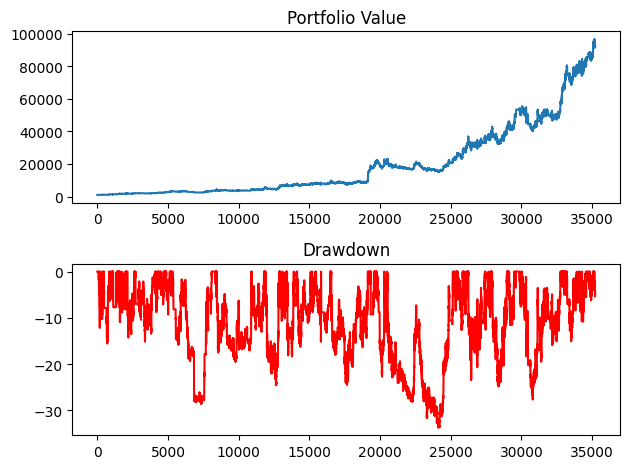

In [66]:
Testing_signals = TradingStrategy(output)
Testing_signals.compounding()

In [67]:
class TradingStrategy:

    def __init__(self, data):

        self.capital = 1000 # this represents the current capital
        self.data = data # this variable is created to use the data inside each function of the class

        self.datetime = [] # datetime colmun, it is for daily trade log, will remain same as in data originally
        self.trade_returns=[]
        self.portfolio_value = [] # this is the temporary portfolio value, which will store for a particular trade, then reset
        self.trade_wise_holding = [] # this represents the holding for each trade
        self.current_position = 0 # this represents the current position (-1 = short, 1 = long, 0 = no position)
        self.holding = 0 # this represents the current holding (temporary variable)

        self.trade_wise_final_portfolio = [] # this represents final portfolio value for each trade

        self.current_portfolio_value = 0 # this represents the current portfolio value (will be updated at each index)

        self.current_stop_loss_value = 0 # this is the temporary variable for the trade in action
        self.current_trade_peak = 0 # this is the maximum portfolio value for trade in action (as we implemented trailing stop-loss)
        self.stop_loss_percent = 0.069 # this is the stop-loss percentage (can be changed as per requirement)

        self.take_profit_value = 0 # this is the temporary variable for the trade in action
        self.take_profit_percent = 100 # this is the take-profit percentage (can be changed as per requirement)

        self.stop_loss_count = [] # this variable is for the count of number of trades exited because of stop-loss
        self.take_profit_count = [] # this variable is for the count of number of trades exited because of take profit

        self.entry = [] # list to store entry index of each trade
        self.exit = [] # list to store exit index of each trade
        self.new_signals = [] # list to new signals, after implementation of stop loss and take profit, and if required, other exit conditions
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each trade
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        # self.transaction_percentage = 0.0015
        self.transaction_cost_per_trade = []
        self.transaction_cost_in_one_trade = 1.5

        self.risk_free_rate = 0.05 # you can change it

        self.drawdown = []
        self.dip = []
        self.trade_wise_returns = []
        self.PL_in_dollars = []

    def calculate_drawdown(self):
        data = self.portfolio_value
        drawdown = []
        temp_peak = data[0]
        for i in range(len(data)):
            if data[i] > temp_peak:
                temp_peak = data[i]
            drawdown.append(-((temp_peak - data[i])/temp_peak) * 100)
        trade_max_drawdown = np.min(drawdown)
        return trade_max_drawdown

    def calculate_dip(self):
        data = self.portfolio_value
        min_portfolio_value = np.min(data)
        dip = (1000 - min_portfolio_value) / 10
        return dip

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.capital = 1000
        self.current_position = 1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding) # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.capital = 1000
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding)
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.capital = 0
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.capital = 1000
        self.drawdown.append(self.calculate_drawdown())
        self.dip.append(self.calculate_dip())
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.transaction_cost_per_trade.append(1 + 0.001 * self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.capital = 1000
        self.drawdown.append(self.calculate_drawdown())
        self.dip.append(self.calculate_dip())
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.transaction_cost_per_trade.append(1 + 0.001 * self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
        return 0

    '''This function is to set the stop-loss depending on entry price'''
    def set_stop_loss(self, i):
        if self.current_position == 1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)
        elif self.current_position == -1:
            self.current_stop_loss_value = (1 - self.stop_loss_percent) * (self.current_trade_peak)

    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    def update_stop_loss(self, i):
        if self.current_position == 1:
            if self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.holding * self.close[i]
                self.set_stop_loss(i)
        elif self.current_position == -1:
            if self.capital - self.holding * self.close[i] > self.current_trade_peak:
                self.current_trade_peak = self.capital - self.holding * self.close[i]
                self.set_stop_loss(i)

    '''This function is to set the take-profit depending on entry price'''
    def set_take_profit(self, i):
        if self.current_position == 1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)
        elif self.current_position == -1:
            self.take_profit_value = (1 + self.take_profit_percent) * (self.current_portfolio_value)

    '''This is the function, which when called will analyse all the trades'''
    def static(self):

        x = len(self.data) - 1 # we don't care about the signal on last date, because we cannot open anew position, and if a position is already open, we must close it
        for i in range(x):
            self.datetime.append(self.data.datetime[i])

            if self.current_position == 0:
                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    self.set_take_profit(i)
                    self.set_stop_loss(i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        self.update_stop_loss(i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        self.update_stop_loss(i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.gross_profit_per_trade = np.array(self.trade_wise_final_portfolio) - 1000
        self.trade_returns= np.array(self.trade_wise_final_portfolio)/10 - 100
        self.net_profit_per_trade = np.array(self.gross_profit_per_trade) - (self.transaction_cost_in_one_trade)

        self.profitable_trade = []
        self.loss_trade = []
        for i in range(len(self.entry)):
            if self.net_profit_per_trade[i] >= 0:
                self.profitable_trade.append(self.net_profit_per_trade[i])
            else:
                self.loss_trade.append(self.net_profit_per_trade[i])

        self.returns = np.sum(self.net_profit_per_trade) / 10

        self.print_parameters()
        return self.create_strategy_dataframes() , self.create_trade_wise_dataframe()

        '''''''''''''''''''''''''''''''''''''''''''''''All parameters calculated'''''''''''''''''''''''''''''''''''''''''''''''


    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    def create_strategy_dataframes(self):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = self.datetime
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        to_submit['signals'] = self.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    def create_trade_wise_dataframe(self):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = self.entry
        trade_wise['exit'] = self.exit
        trade_wise['duration'] = self.trade_wise_duration
        trade_wise['quantity'] = self.trade_wise_holding
        trade_wise['trade type'] = self.trade_type
        trade_wise['final portfolio value'] = self.trade_wise_final_portfolio
        trade_wise['returns']=self.trade_returns
        trade_wise['drawdown'] = self.drawdown
        trade_wise['dip'] = self.dip
        return trade_wise

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    def print_parameters(self):
        print('Number of closed trade:',len(self.entry))
        print('Winning trades:',len(self.profitable_trade))
        print('Losing trades:',len(self.loss_trade))
        print('Benchmark returns:',self.benchmark_return)
        print('Win rate:',(len(self.profitable_trade)/len(self.entry))*100)
        print('Gross profit:',np.sum(self.gross_profit_per_trade))
        print('Net profit:',np.sum(self.net_profit_per_trade))
        print('Average profit:',np.mean(self.net_profit_per_trade))
        print('Maximum drawdown:',max_drawdown(self.trade_returns/100)*100)
        print('Largest win:',np.max(self.profitable_trade))
        print('Average win:',np.mean(self.profitable_trade))
        print('Largest loss:',np.min(self.loss_trade))
        print('Average loss:',np.mean(self.loss_trade))
        print('Maximum holding time:',np.max(self.trade_wise_duration))
        print('Average holding time:',np.mean(self.trade_wise_duration))
        print('Maximum dip:',np.max(self.dip))
        print('Average dip:',np.mean(self.dip))
        print('Returns:',self.returns ,'%')
        print('Number of times stop-loss met:',len(self.stop_loss_count))
        print('Number of time take-profit met:',len(self.take_profit_count))
        print('Sharpe ratio:',sharpe_ratio(self.trade_returns))

In [68]:
Testing_signals = TradingStrategy(data)
to_submit, trade_wise = Testing_signals.static()

Number of closed trade: 185
Winning trades: 80
Losing trades: 105
Benchmark returns: 2154.3328004044643
Win rate: 43.24324324324324
Gross profit: 4297.112119708547
Net profit: 4019.6121197085467
Average profit: 21.727633079505658
Maximum drawdown: -24.544919535718577
Largest win: 530.4255027966203
Average win: 98.44797360029585
Largest loss: -103.48333711141413
Average loss: -36.72595969823925
Maximum holding time: 725
Average holding time: 141.54594594594596
Maximum dip: 10.198333711141412
Average dip: 2.6418588124806868
Returns: 401.96121197085466 %
Number of times stop-loss met: 89
Number of time take-profit met: 0
Sharpe ratio: 3.754206369582975
